In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

import plates

dataDir = '00.1-data/platereader'
files = [os.path.join(dataDir, i) for i in os.listdir(dataDir)]
files

['00.1-data/platereader/00.1-2022-03-02-incr-prot-vol.CSV',
 '00.1-data/platereader/2022-03-02-00.1-prot-30degC.CSV',
 '00.1-data/platereader/00.1-2022-03-02-plate0-blank.CSV',
 '00.1-data/platereader/2022-03-02-00.1-prot-30deg-mtrx.CSV']

In [3]:
test = plates.Plate('00.1-data/platereader/2022-03-02-00.1-prot-30degC.CSV')
ctrl = plates.Plate('00.1-data/platereader/00.1-2022-03-02-plate0-blank.CSV')

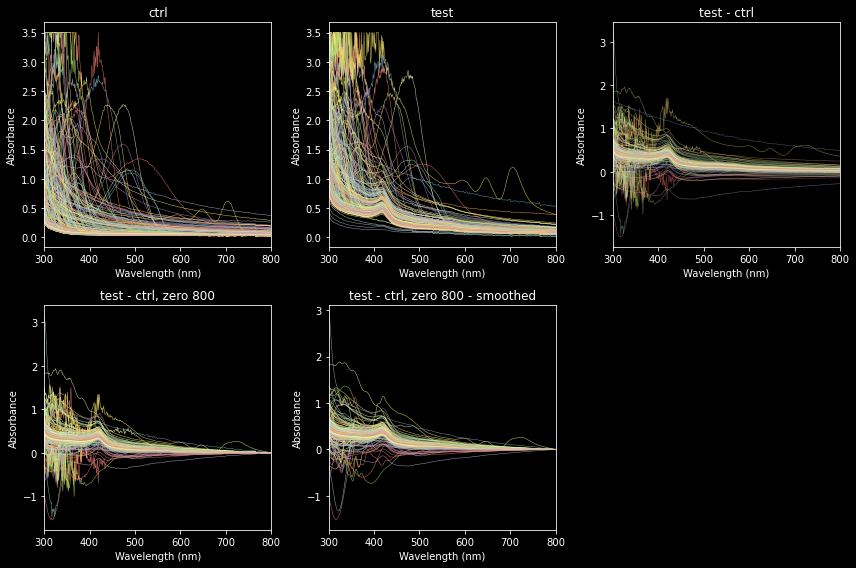

In [30]:
from scipy import ndimage

fig, ax = plt.subplots(2,3, figsize=(12,8))

for i in ctrl.df.index:
    x = ctrl.df.loc[i,:]
    ax[0,0].plot(x, lw=0.5, alpha=0.8)
ax[0,0].set_xlabel('Wavelength (nm)')
ax[0,0].set_ylabel('Absorbance')
ax[0,0].set_xlim(300,800)
ax[0,0].set_title('ctrl')

for i in ctrl.df.index:
    x = test.df.loc[i,:]
    ax[0,1].plot(x, lw=0.5, alpha=0.8)
ax[0,1].set_xlabel('Wavelength (nm)')
ax[0,1].set_ylabel('Absorbance')
ax[0,1].set_xlim(300,800)
ax[0,1].set_title('test')


for i in test.df.index:
    ax[0,2].plot(test.df.loc[i,:] - ctrl.df.loc[i,:], lw=0.5, alpha=0.5)
ax[0,2].set_xlabel('Wavelength (nm)')
ax[0,2].set_ylabel('Absorbance')
ax[0,2].set_xlim(300,800)
ax[0,2].set_title('test - ctrl')

for i in test.df.index:
    x = test.df.loc[i,:] - ctrl.df.loc[i,:]
    x -= x.loc[800]
    ax[1,0].plot(x, lw=0.5, alpha=0.8)
ax[1,0].set_xlabel('Wavelength (nm)')
ax[1,0].set_ylabel('Absorbance')
ax[1,0].set_xlim(300,800)
ax[1,0].set_title('test - ctrl, zero 800')

for i in test.df.index:
    ztest = test.df.loc[i,:] - test.df.loc[i,800]
    zctrl = ctrl.df.loc[i,:] - ctrl.df.loc[i,800]
    smthtest = pd.Series(ndimage.gaussian_filter(ztest, 3), index=ztest.index)
    smthctrl = pd.Series(ndimage.gaussian_filter(zctrl, 3), index=zctrl.index)
    x = smthtest - smthctrl
    ax[1,1].plot(x, lw=0.5, alpha=0.8)
ax[1,1].set_xlabel('Wavelength (nm)')
ax[1,1].set_ylabel('Absorbance')
ax[1,1].set_xlim(300,800)
ax[1,1].set_title('test - ctrl, zero 800 - smoothed')


#for i in test.df.index:
#    x = test.df.loc[i,:] - ctrl.df.loc[i,:]
#    x -= ndimage.gaussian_filter(x.loc[800], 3)
#    ax[1,2].plot(x, lw=0.5, alpha=0.8)
#ax[1,2].set_xlabel('Wavelength (nm)')
#ax[1,2].set_ylabel('Absorbance')
#ax[1,2].set_xlim(300,800)
ax[1,2].axis('off')
plt.tight_layout()
plt.show()

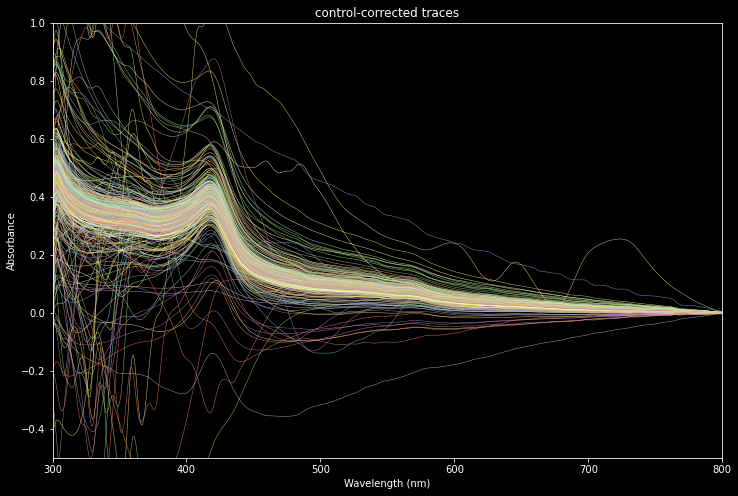

In [95]:
ztest = test.df.sub(test.df.loc[:,800],axis=0)
zctrl = ctrl.df.sub(ctrl.df.loc[:,800],axis=0)
smthtest = pd.DataFrame(ndimage.gaussian_filter1d(ztest, 3,axis=-1), 
                        index=ztest.index, 
                        columns=ztest.columns)
smthctrl = pd.DataFrame(ndimage.gaussian_filter1d(zctrl, 3,axis=-1), 
                        index=zctrl.index, 
                        columns=zctrl.columns)
x = smthtest - smthctrl

plt.figure(figsize=(12,8))
for i in x.index:
    plt.plot(x.loc[i,:], lw=0.5, alpha=0.8)
plt.xlim(300,800)
plt.ylim(-0.5,1)
plt.title('control-corrected traces')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.show()

## Anomaly Detection

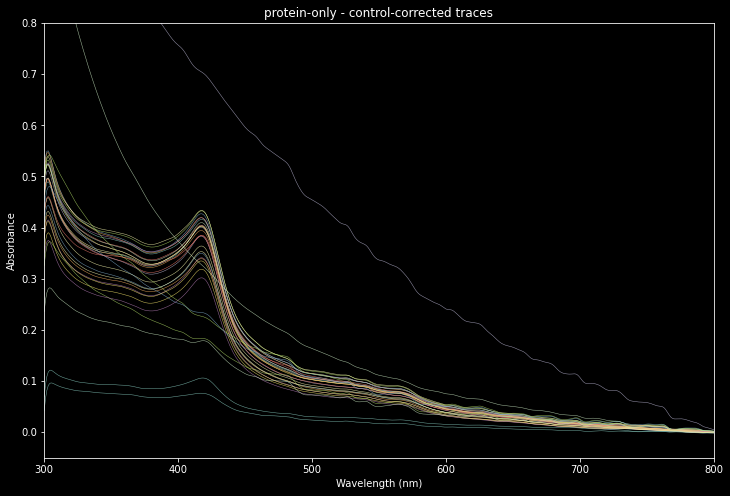

In [65]:
prot_only = x.loc['A23':,:].dropna(axis=1)


plt.figure(figsize=(12,8))
for i in prot_only.index:
    plt.plot(prot_only.loc[i,:], lw=0.5, alpha=0.8)
plt.xlim(300,800)
plt.ylim(-0.05,0.8)
plt.title('protein-only - control-corrected traces')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.show()

## Soret shifts
The absorbance shift at 420 and 390 nm are very variable in the protein only group.

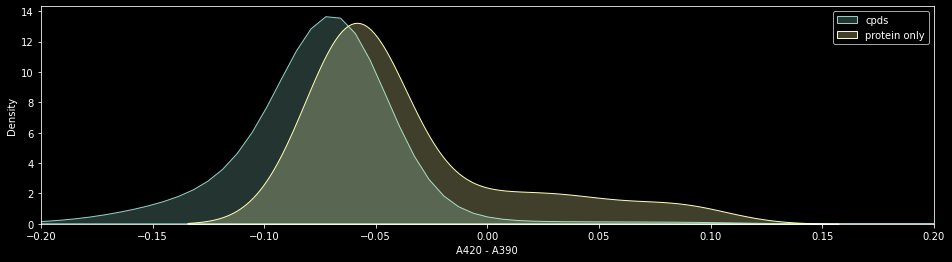

In [94]:
import seaborn as sns
wcpds = x.drop(prot_only.index)
plt.figure(figsize=(16,4))
sns.kdeplot(wcpds[390] - wcpds[420], label='cpds', fill=True)
sns.kdeplot(prot_only[390] - prot_only[420], label='protein only', fill=True)
plt.xlabel('A420 - A390')
plt.xlim(-0.2,0.2)
plt.legend()
plt.show()

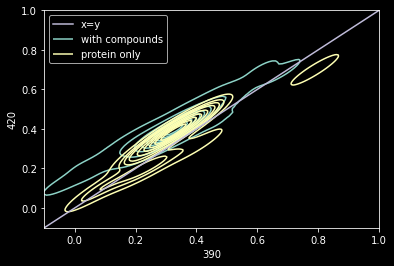

In [131]:
sns.kdeplot(x=wcpds[390], y=wcpds[420])
sns.kdeplot(x=prot_only[390], y=prot_only[420])
plt.plot([-0.1,1],[-0.1,1])
plt.xlim(-0.1,1)
plt.ylim(-0.1,1)
plt.legend(['x=y',
            'with compounds',
            'protein only',])
plt.show()

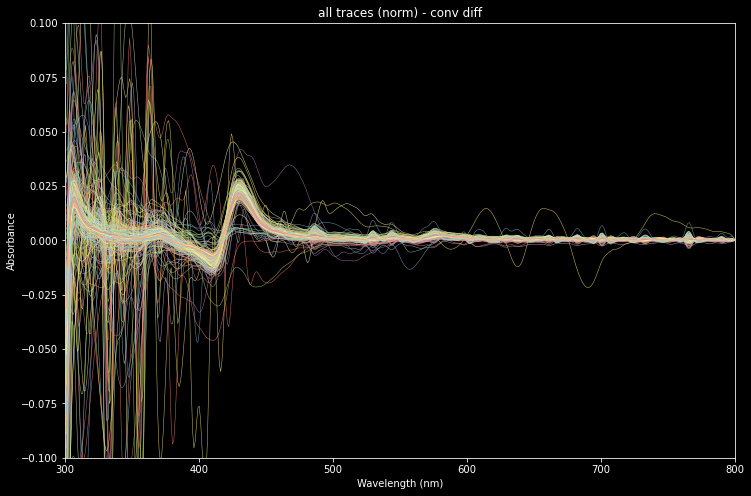

In [108]:
diff = np.array([-1.0,0.0,1.0])
conv_diff = pd.DataFrame(ndimage.convolve1d(x,diff), columns=x.columns)

plt.figure(figsize=(12,8))
for i in conv_diff.index:
    plt.plot(conv_diff.loc[i,:], lw=0.5, alpha=0.8)
plt.xlim(300,800)
plt.ylim(-0.1,0.1)
plt.title('all traces (norm) - conv diff')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.show()


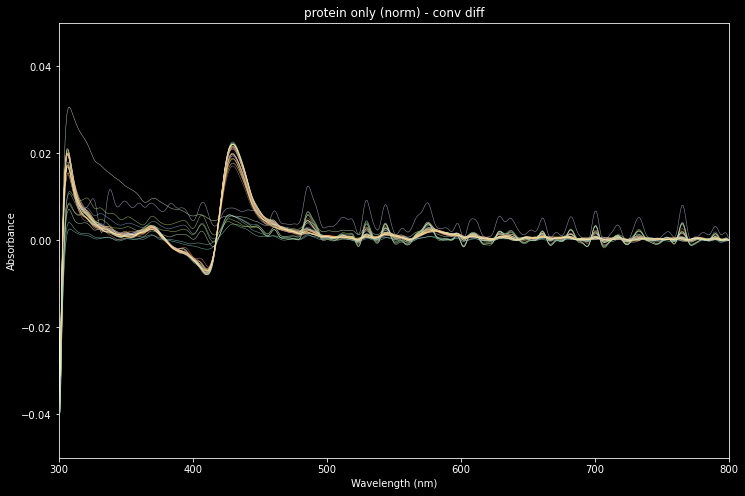

In [113]:
conv_diff_prot = pd.DataFrame(ndimage.convolve1d(prot_only,diff), columns=prot_only.columns)

plt.figure(figsize=(12,8))
for i in conv_diff_prot.index:
    plt.plot(conv_diff_prot.loc[i,:], lw=0.5, alpha=0.8)
plt.xlim(300,800)
plt.ylim(-0.05,0.05)
plt.title('protein only (norm) - conv diff')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.show()

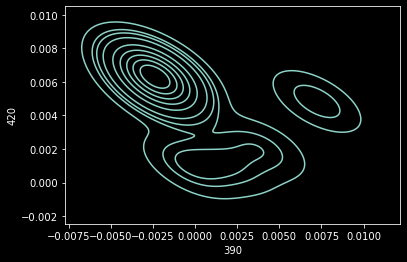

In [119]:
sns.kdeplot(x=conv_diff_prot[390],
            y=conv_diff_prot[420])
plt.show()

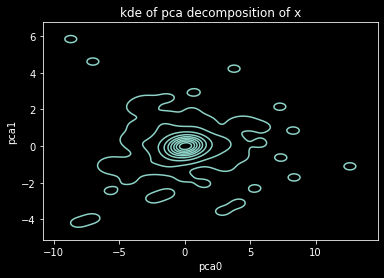

In [118]:
from sklearn.decomposition import PCA

pca = PCA()
decomp = pca.fit_transform(x.fillna(3.5))
sns.kdeplot(x=decomp[:,0], y=decomp[:,1])
plt.title('kde of pca decomposition of x')
plt.xlabel('pca0')
plt.ylabel('pca1')
plt.show()

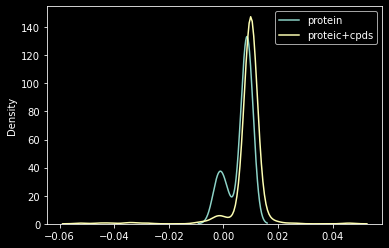

In [134]:
sns.kdeplot(conv_diff_prot[420] - conv_diff_prot[390])
sns.kdeplot(conv_diff[420] - conv_diff[390])
plt.legend(['protein', 'proteic+cpds'])
plt.show()